# Exploring CAFE-f6 bias correction

In [1]:
import dask

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

dask.config.set(**{"array.slicing.split_large_chunks": False})

In [2]:
from src import utils
from src import open_

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
xr.set_options(keep_attrs=True)

# Cluster

In [30]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

walltime = "04:00:00"
cores = 48
memory = "192GB"
cluster = PBSCluster(
    processes=1,
    walltime=str(walltime),
    cores=cores,
    memory=str(memory),
    job_extra=[
        "-l ncpus=" + str(cores),
        "-l mem=" + str(memory),
        "-P xv83",
        "-l jobfs=100GB",
        "-l storage=gdata/xv83+gdata/oi10",
    ],
    local_directory="$PBS_JOBFS",
    # env_extra=['export MALLOC_TRIM_THRESHOLD_="0"'],
    header_skip=["select"],
)

In [31]:
cluster.scale(jobs=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.41.33:8787/status,
Dashboard: http://10.6.41.33:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.41.33:40881,Workers: 0
Dashboard: http://10.6.41.33:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Prepare some data - CAFE hindcasts
Use only the November forecasts, due to issue with changing executable for May forecasts

In [61]:
def global_mean(ds, area, dims):
    return ds.weighted(area).mean(dims)

In [62]:
def preprocess(ds):
    return utils.coarsen_monthly_to_annual(ds, dim="lead")

In [63]:
realm = "atmos_isobaric_month"
variables = ["t_ref", "precip"]

ds = open_.CAFEf6(realm, variables, preprocess)
cafe_atmos_area = ds["area"]
f6_hcst = global_mean(ds.mean("ensemble"), cafe_atmos_area, ["lon", "lat"]).compute()

ds = open_.CAFEf5(realm, variables, preprocess)
f5_hcst = global_mean(ds.mean("ensemble"), cafe_atmos_area, ["lon", "lat"]).compute()

In [64]:
realm = "ocean_month"
variables = ["sst"]

ds = open_.CAFEf6(realm, variables, preprocess)
cafe_ocean_area = ds["area_t"]
ds_gbl = global_mean(
    ds.mean("ensemble"), cafe_ocean_area, ["xt_ocean", "yt_ocean"]
).compute()
f6_hcst = xr.merge([f6_hcst, ds_gbl])

ds = open_.CAFEf5(realm, variables, preprocess)
ds_gbl = global_mean(
    ds.mean("ensemble"), cafe_ocean_area, ["xt_ocean", "yt_ocean"]
).compute()
f5_hcst = xr.merge([f5_hcst, ds_gbl])

# Prepare some data - CAFE60

In [65]:
ds = open_.CAFE60v1("atmos_isobaric_month", ["t_ref", "precip"])
ds = utils.coarsen_monthly_to_annual(ds, f5_hcst.init[0], dim="time")
cafe_60 = global_mean(ds.mean("ensemble"), cafe_atmos_area, ["lon", "lat"]).compute()

In [66]:
ds = open_.CAFE60v1("ocean_month", ["sst"])
ds = utils.coarsen_monthly_to_annual(ds, f5_hcst.init[0], dim="time")
ds_gbl = global_mean(
    ds.mean("ensemble"), cafe_ocean_area, ["xt_ocean", "yt_ocean"]
).compute()
cafe_60 = xr.merge([cafe_60, ds_gbl])

# Prepare some data - CAFE historical

In [67]:
ds = open_.CAFEh0("atmos_isobaric_month", ["t_ref", "precip"])
ds = utils.coarsen_monthly_to_annual(ds, f5_hcst.init[0], dim="time")
cafe_hist = global_mean(ds.mean("ensemble"), cafe_atmos_area, ["lon", "lat"]).compute()

In [68]:
ds = open_.CAFEh0("ocean_month", ["sst"])
ds = utils.coarsen_monthly_to_annual(ds, f5_hcst.init[0], dim="time")
ds_gbl = global_mean(
    ds.mean("ensemble"), cafe_ocean_area, ["xt_ocean", "yt_ocean"]
).compute()
cafe_hist = xr.merge([cafe_hist, ds_gbl])

# Prepare some data - JRA55

In [164]:
ds = open_.JRA55("surface_month_cafe-grid", ["t_ref", "precip"])
ds1 = utils.coarsen_monthly_to_annual(ds, f5_hcst.init[0], dim="time")
ds2 = utils.coarsen_monthly_to_annual(ds, CanESM5_hcst.init[0], dim="time")
ds = xr.concat([ds1, ds2], dim="time").sortby("time")
obs = global_mean(ds, cafe_atmos_area, ["lon", "lat"]).compute()

/g/data/xv83/users/ds0092/software/miniconda3/envs/cafe-f6_analysis/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]
/g/data/xv83/users/ds0092/software/miniconda3/envs/cafe-f6_analysis/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 40 times more chunks
  return self.array[key]


# Prepare some data - HadISST

In [169]:
ds = open_.HadISST()

ds1 = utils.coarsen_monthly_to_annual(ds, f5_hcst.init[0], dim="time")
ds2 = utils.coarsen_monthly_to_annual(ds, CanESM5_hcst.init[0], dim="time")
ds = xr.concat([ds1, ds2], dim="time").sortby("time")
had_area = utils.estimate_cell_areas(ds)
obs = xr.merge([obs, global_mean(ds, had_area, ["lon", "lat"]).compute()])

/g/data/xv83/users/ds0092/software/miniconda3/envs/cafe-f6_analysis/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]


# Prepare some data - CanESM5

In [225]:
realm = "Amon"
variables = ["t_ref", "precip"]

ds = open_.CanESM5(realm, variables)
ds["precip"] = ds["precip"] * ds.time.dt.days_in_month
ds = utils.coarsen_monthly_to_annual(ds, dim="lead")

CanEMS5_atmos_area = xr.open_dataset("../../data/raw/CanESM5/CanESM5_atmos_gn_area.nc")[
    "cell_area"
]
CanESM5_hcst = global_mean(
    ds.mean("member"), CanEMS5_atmos_area, ["lon", "lat"]
).compute()

In [226]:
realm = "Omon"
variables = ["sst"]

ds = open_.CanESM5(realm, variables)
ds = utils.coarsen_monthly_to_annual(ds, dim="lead")

CanEMS5_ocean_area = xr.open_dataset("../../data/raw/CanESM5/CanESM5_ocean_gn_area.nc")[
    "cell_area"
]
ds_gbl = global_mean(ds.mean("member"), CanEMS5_ocean_area, ["i", "j"]).compute()
CanESM5_hcst = xr.merge([CanESM5_hcst, ds_gbl])

# Remove the biases

### Calculate the biases from the f6 climatology over the max consistent period

In [252]:
def bias_mean(hcst, obs):
    hcst_clim = hcst.mean("init")
    obs_clim = obs.mean("time")
    return hcst_clim - obs_clim

In [253]:
period = [cftime.DatetimeJulian(1990, 1, 1), cftime.DatetimeJulian(2018, 1, 1)]

hcst_period = (f6_hcst.time >= period[0]) & (f6_hcst.time <= period[1])
obs_period = np.unique(f6_hcst.time.values[hcst_period.values])
bias = bias_mean(
    f6_hcst.where(hcst_period),
    obs.sel(time=obs_period),
)


f6_hcst_bc = f6_hcst - bias

In [254]:
def plot_hindcasts(hcsts, hcsts_bc):
    from matplotlib.pyplot import cm
    from matplotlib.dates import date2num

    def shading(ax):
        trans = cftime.DatetimeJulian(1992, 1, 1)
        end = cftime.DatetimeJulian(2040, 1, 1)
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.fill_between(
            [trans, end],
            [ylim[1], ylim[1]],
            [ylim[0], ylim[0]],
            color=[0.9, 0.9, 0.9],
        )
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    n_vars = len(hcsts.data_vars)

    fig = plt.figure(figsize=(10, n_vars * 4))
    axs = fig.subplots(n_vars, 1, sharex=True)
    if n_vars == 1:
        axs = [axs]

    for a, var in enumerate(hcsts.data_vars):
        color = cm.autumn(np.linspace(0, 0.9, len(hcsts[var].init)))
        color_bc = cm.winter(np.linspace(0, 0.9, len(hcsts[var].init)))
        for idx, (i, c) in enumerate(zip(hcsts[var].init, color)):
            if idx == 0:
                label = "Hindcasts raw"
            else:
                label = "_nolabel_"

            hcst = hcsts[var].sel(init=i)
            axs[a].plot(hcst.time[0], hcst[0], color=c, marker="o", label="_nolabel_")
            axs[a].plot(hcst.time, hcst, color=c, linestyle="-", label=label)

        for idx, (i, c) in enumerate(zip(hcsts_bc[var].init, color_bc)):
            if idx == 0:
                label = "Hindcasts bias corrected"
            else:
                label = "_nolabel_"
            hcst = hcsts_bc[var].sel(init=i)
            axs[a].plot(hcst.time[0], hcst[0], color=c, marker="o", label="_nolabel_")
            axs[a].plot(hcst.time, hcst, color=c, linestyle="-", label=label)

        axs[a].plot(obs.time, obs[var], color="black", label="Observations")
        axs[a].plot(
            cafe_60.time, cafe_60[var], color="black", linestyle="--", label="CAFE60v1"
        )
        axs[a].plot(
            cafe_hist.time, cafe_hist[var], color="grey", label="CAFE-historical"
        )

        ticks = xr.cftime_range(
            start="1981-01-01", end="2032-01-01", freq="2AS", calendar="julian"
        )
        axs[a].set_xticks(ticks.values)
        axs[a].set_xticklabels(ticks.year)
        axs[a].set_xlim(
            cftime.DatetimeJulian(1981, 1, 1), cftime.DatetimeJulian(2032, 1, 1)
        )
        axs[a].set_ylabel(hcsts[var].attrs["long_name"])
        axs[a].grid()
        if a == 0:
            axs[a].legend()
        if a == (n_vars - 1):
            axs[a].set_xlabel("year")
        else:
            axs[a].set_xlabel("")

        shading(axs[a])

    plt.tight_layout()

    return fig

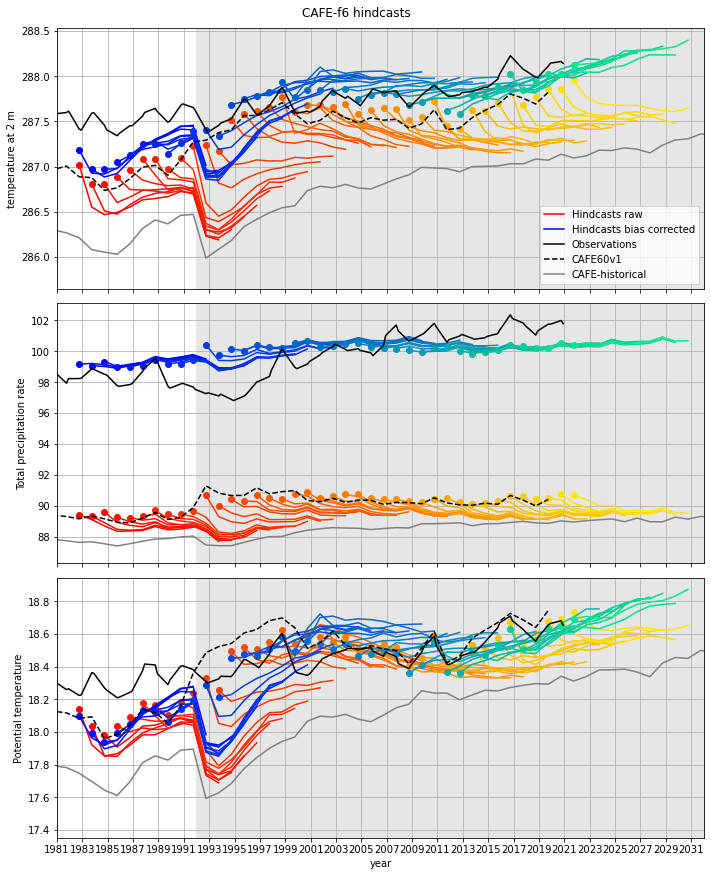

In [260]:
fig = plot_hindcasts(f6_hcst, f6_hcst_bc)
fig.suptitle("CAFE-f6 hindcasts", fontsize=12, y=1.01)
fig.patch.set_facecolor("w")

fig.savefig(f"CAFE-f6_hindcasts.png", format="png", bbox_inches="tight")

### What does can CanESM5 look like?

In [256]:
period = [cftime.DatetimeJulian(1990, 1, 1), cftime.DatetimeJulian(2018, 1, 1)]

hcst_period = (CanESM5_hcst.time >= period[0]) & (CanESM5_hcst.time <= period[1])
obs_period = np.unique(CanESM5_hcst.time.values[hcst_period.values])
bias = bias_mean(
    CanESM5_hcst.where(hcst_period),
    obs.sel(time=obs_period),
)


CanESM5_hcst_bc = CanESM5_hcst - bias

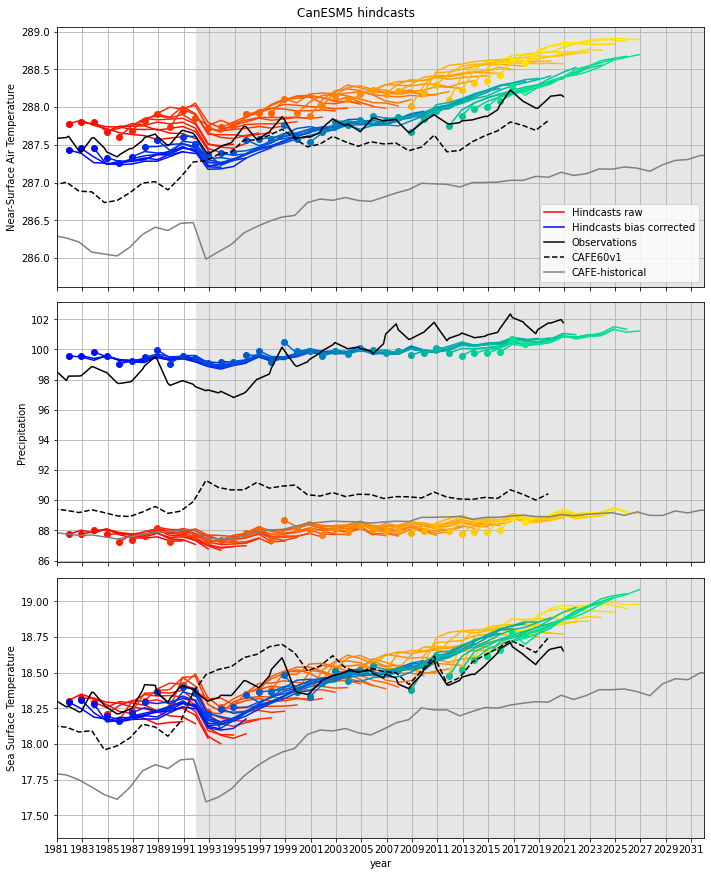

In [259]:
fig = plot_hindcasts(CanESM5_hcst, CanESM5_hcst_bc)
fig.suptitle("CanESM5 hindcasts", fontsize=12, y=1.01)
fig.patch.set_facecolor("w")

fig.savefig(f"CanESM_hindcasts.png", format="png", bbox_inches="tight")

### That obviously has quite a large step around 1992 due to the change to CAFE60's bias-correction scheme.

### What about if we calculate anomalies for pre and post 1992 separately? Let's use CAFE-f5 so that we can use the same length period for bias correction pre and post the change.

In [21]:
transition_year = 1992

period_1 = [
    cftime.DatetimeJulian(1973, 10, 1),
    cftime.DatetimeJulian(1992, 10, 1),
]  # 20 years, using initial dates < 1992
period_2 = [
    cftime.DatetimeJulian(2002, 10, 1),
    cftime.DatetimeJulian(2021, 10, 1),
]  # 20 years, using initial dates >= 1992

bias_1 = bias_mean(
    f5_hcst.where((f5_hcst.time >= period_1[0]) & (f5_hcst.time <= period_1[1])),
    obs.where((obs.time >= period_1[0]) & (obs.time <= period_1[1])),
)

bias_2 = bias_mean(
    f5_hcst.where((f5_hcst.time >= period_2[0]) & (f5_hcst.time <= period_2[1])),
    obs.where((obs.time >= period_2[0]) & (obs.time <= period_2[1])),
)

f6_hcst_bc1 = f6_hcst.sel(init=slice(None, str(transition_year - 1))) - bias_1
f6_hcst_bc2 = f6_hcst.sel(init=slice(str(transition_year), None)) - bias_2
f6_hcst_bc = xr.concat((f6_hcst_bc1, f6_hcst_bc2), dim="init")

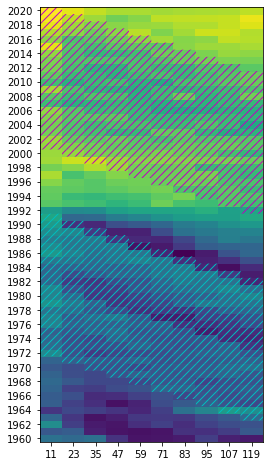

In [22]:
fig, ax = plt.subplots(figsize=(4, 8))

x = np.arange(len(f5_hcst.lead) + 1)
y = np.arange(1, len(f5_hcst.init) + 2) - 0.5
c = f5_hcst["sst"].transpose("init", "lead")
im = ax.pcolor(x, y, c)

ax.set_xticks(np.arange(len(f5_hcst.lead)) + 0.5)
ax.set_xticklabels(f5_hcst.lead.values)
ax.set_yticks(np.arange(1, len(f5_hcst.init) + 1, 2))
ax.set_yticklabels(f5_hcst.init.dt.year.values[::2])


def hatch(mask, color):
    import matplotlib.patches as mpatches

    for j, i in np.column_stack(np.where(mask)):
        ax.add_patch(
            mpatches.Rectangle(
                (i, j + 0.5),
                1,
                1,
                fill=False,
                linewidth=0,
                snap=False,
                color=color,
                hatch="///",
            )
        )


mask = xr.ones_like(f5_hcst["t_ref"]).where(
    (f5_hcst.time >= period_1[0]) & (f5_hcst.time <= period_1[1]),
    0,
)
hatch(mask, "c")
mask = xr.ones_like(f5_hcst["t_ref"]).where(
    (f5_hcst.time >= period_2[0]) & (f5_hcst.time <= period_2[1]),
    0,
)
hatch(mask, "m")

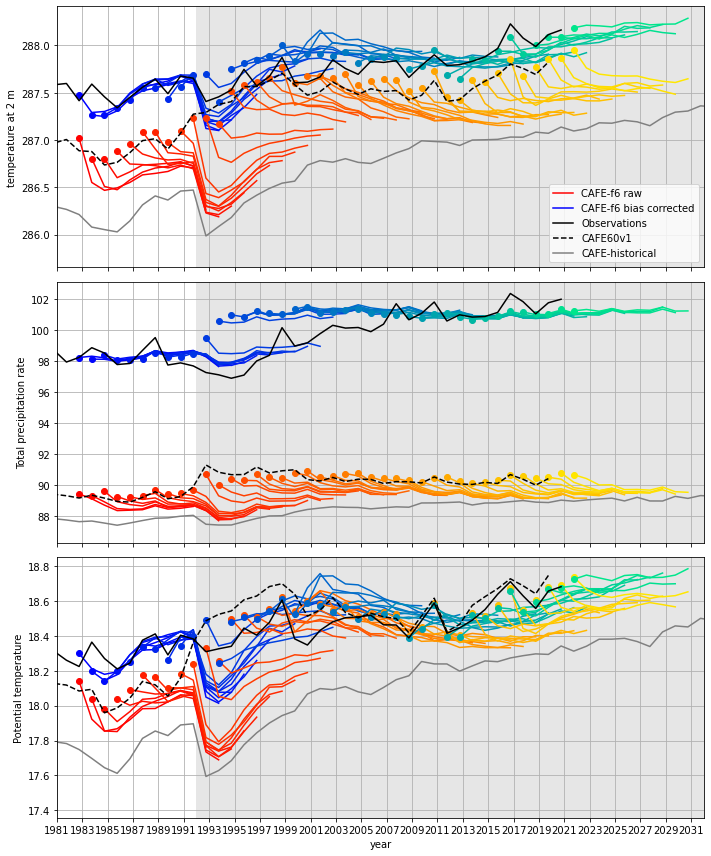

In [23]:
_ = plot_hindcasts(f6_hcst, f6_hcst_bc)

### Looks okay for `t_ref` and `sst` but not `precip`... What about if we do the same thing but don't limit ourselves to a consistent period at each lead

In [24]:
transition_year = 1992

period_1 = slice(
    cftime.DatetimeJulian(1963, 11, 1),
    cftime.DatetimeJulian(1991, 11, 1),
)  # 28 years
period_2 = slice(
    cftime.DatetimeJulian(1992, 11, 1),
    cftime.DatetimeJulian(2020, 11, 1),
)  # 28 years

f5_period_1 = f5_hcst.sel(init=period_1)
bias_1 = []
for l in f5_period_1.lead:
    ts = f5_period_1.sel(lead=l).swap_dims({"init": "time"})
    bias_1.append((ts - obs).mean("time").expand_dims({"lead": [l]}))
bias_1 = xr.concat(bias_1, dim="lead")

f5_period_2 = f5_hcst.sel(init=period_2)
bias_2 = []
for l in f5_period_2.lead:
    ts = f5_period_2.sel(lead=l).swap_dims({"init": "time"})
    bias_2.append((ts - obs).mean("time").expand_dims({"lead": [l]}))
bias_2 = xr.concat(bias_2, dim="lead")

f6_hcst_bc1 = f6_hcst.sel(init=slice(None, str(transition_year - 1))) - bias_1
f6_hcst_bc2 = f6_hcst.sel(init=slice(str(transition_year), None)) - bias_2
f6_hcst_bc = xr.concat((f6_hcst_bc1, f6_hcst_bc2), dim="init")

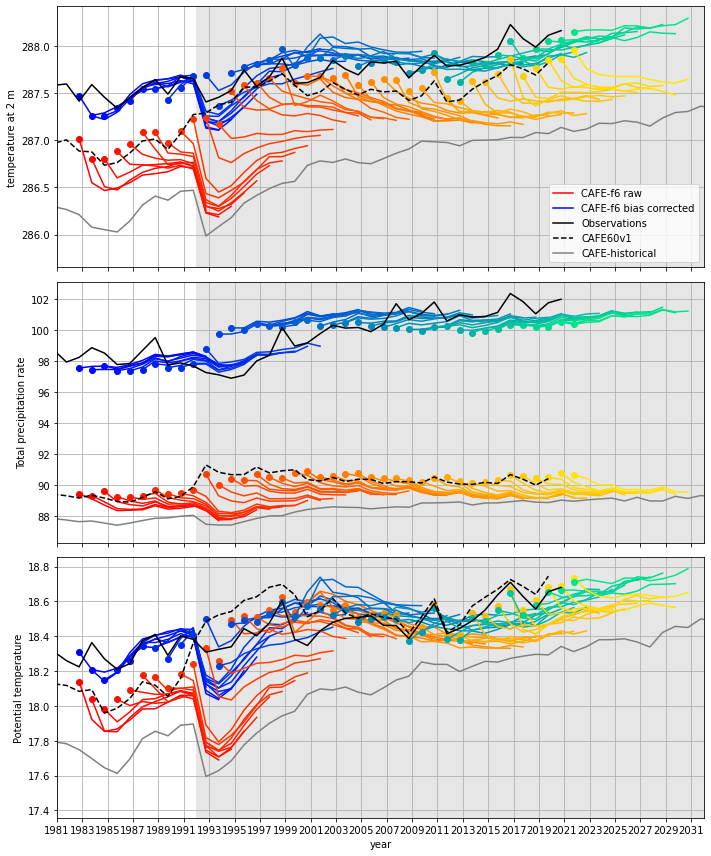

In [25]:
_ = plot_hindcasts(f6_hcst, f6_hcst_bc)

### Still not great... What about correcting for the biases on a sliding window basis, using the previous 12 years of data?

e.g. 
- for the 1981 forecast, biases are calculated over the period 1970-1981 at all leads
- for the 2020 forecast, biases are calculated over the period 2009-2020 at all leads 

This is a fair approach, but it will have to use the f5 forecasts to calculate the biases

In [26]:
n_years = 12

objs = []
for init in f6_hcst.init:
    hcst = f6_hcst.sel(init=[init.item()])

    # Calculate the bias
    clim_range = [
        hcst.get_index("init").shift(-(12 * n_years), "MS").item(),
        hcst.get_index("init").item(),
    ]
    bias = bias_mean(
        f5_hcst.where(
            (f5_hcst.time >= clim_range[0]) & (f5_hcst.time <= clim_range[1])
        ),
        obs.where((obs.time >= clim_range[0]) & (obs.time <= clim_range[1])),
    )

    objs.append(hcst - bias)

f6_hcst_bc = xr.concat(objs, dim="init")

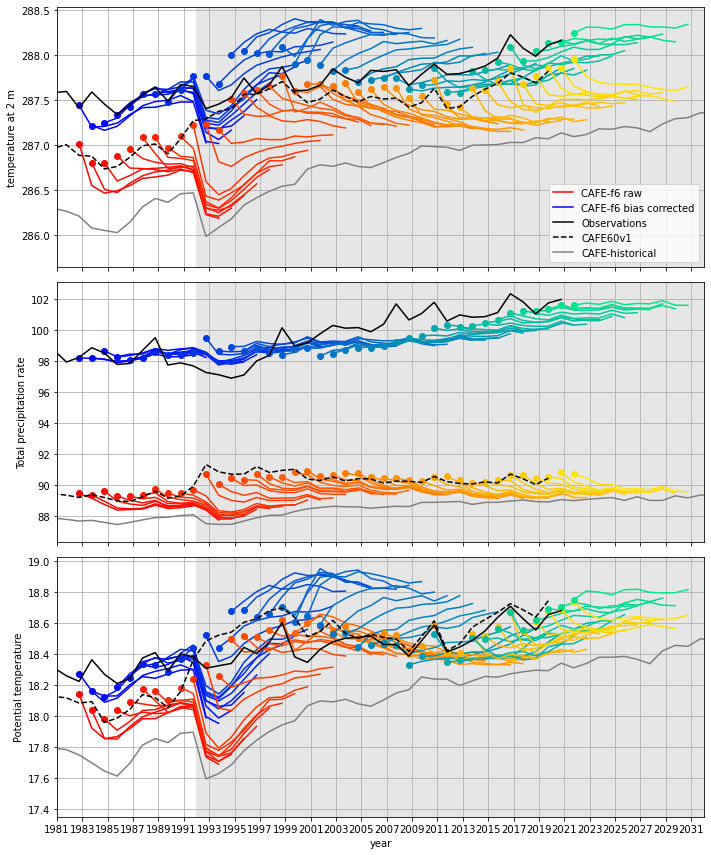

In [27]:
_ = plot_hindcasts(f6_hcst, f6_hcst_bc)

### What about doing this in an unfair way, selecting the period based on initial date alone?
This approach uses observations from the future to perform the bias correction at non-zero leads

In [28]:
n_years = 20

objs = []
for init in f6_hcst.init:
    hcst = f6_hcst.sel(init=[init.item()])

    init_range = slice(
        hcst.get_index("init").shift(-(12 * (n_years - 1)), "MS").item(),
        hcst.get_index("init").item(),
    )
    f5_period = f5_hcst.sel(init=init_range)
    bias = []
    for l in f5_period.lead:
        ts = f5_period.sel(lead=l).swap_dims({"init": "time"})
        bias.append((ts - obs).mean("time").expand_dims({"lead": [l]}))
    bias = xr.concat(bias, dim="lead")

    objs.append(hcst - bias)

f6_hcst_bc = xr.concat(objs, dim="init")

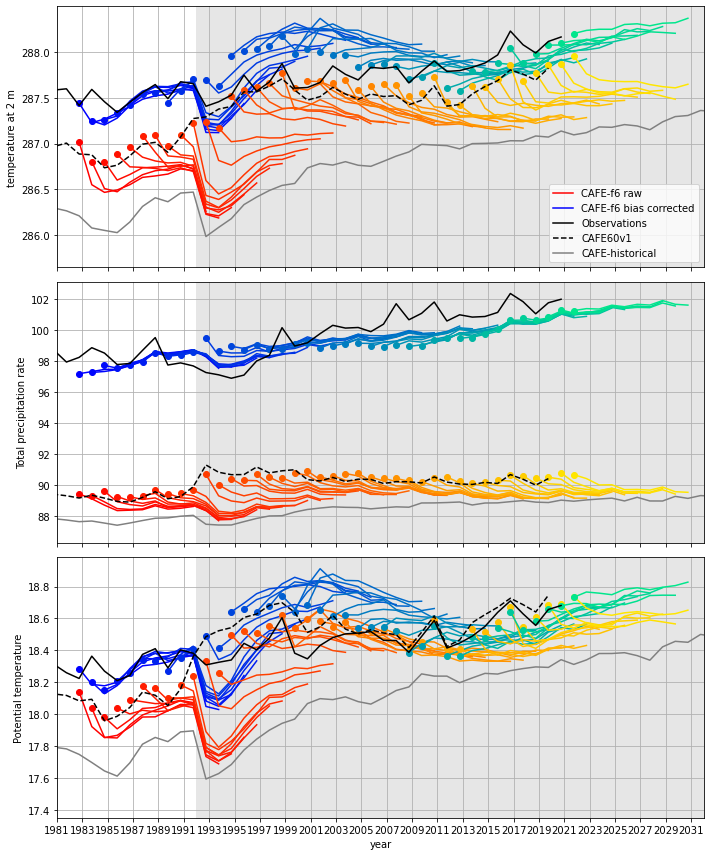

In [29]:
_ = plot_hindcasts(f6_hcst, f6_hcst_bc)

### What about fitting an exponential?
Of the form $D(l>0) = D(l=0) \exp(-A l)$ where $D = F - H$ is the deviation between the forecast, $F$, and the historical run, $H$; and $l$ is the lead time.

In [30]:
var = "t_ref"  # Only works on DataArrays

In [31]:
res = []
for i in f6_hcst.init:
    hcst = f6_hcst.sel(init=i).swap_dims({"lead": "time"})
    res.append((hcst - cafe_hist)[var].swap_dims({"time": "lead"}))

f6_D = xr.concat(res, dim="init")

In [32]:
from scipy.optimize import leastsq


def multiple_reg(x, y, f, const, params0, **kwargs):
    """Do same non-linear regression on multiple curves"""

    def leastsq_func(params, *args):
        x, y = args[:2]
        const = args[2:]
        yfit = []
        for i in range(len(x)):
            yfit = np.append(yfit, f(x[i], *const[i], *params))
        return y - yfit

    # turn const into 2d-array if 1d is given
    const = np.asarray(const)
    if len(const.shape) < 2:
        const = np.atleast_2d(const).T

    # ensure that y is flat and x is nested
    if hasattr(y[0], "__len__"):
        y = [item for sublist in y for item in sublist]
    if not hasattr(x[0], "__len__"):
        x = np.tile(x, (len(const), 1))
    x_ = [item for sublist in x for item in sublist]
    assert len(x_) == len(y)

    # collect all arguments in a tuple
    y = np.asarray(y)
    args = [x, y] + list(const)
    args = tuple(args)  # doesn't work if args is a list!!

    return leastsq(leastsq_func, params0, args=args, **kwargs)

In [33]:
def fit(x, D0, A, B):
    return B * D0 * np.exp(-A * x)  # B * D0 + B * D0 * np.tanh(-A * x)  #


p, _ = multiple_reg(
    f6_D.lead.values[1:], f6_D.values[:, 1:], fit, f6_D.values[:, 0], [0.1, 1]
)

In [34]:
f6_hcst_bc = []
f6_hcst_fit = []
for i in f6_D.init:
    f6_D_ts = f6_D.sel(init=i).swap_dims({"lead": "time"})
    f6_hcst_ts = f6_hcst.sel(init=i).swap_dims({"lead": "time"})
    D_fit = fit(f6_D_ts.lead, f6_D_ts.values[0], p[0], p[1])
    D_fit = xr.zeros_like(f6_hcst_ts) + D_fit
    f6_hcst_bc.append((f6_hcst_ts - D_fit).swap_dims({"time": "lead"}))
    f6_hcst_fit.append((D_fit + cafe_hist).swap_dims({"time": "lead"}))

f6_hcst_bc = xr.concat(f6_hcst_bc, dim="init")
f6_hcst_fit = xr.concat(f6_hcst_fit, dim="init")

period = [cftime.DatetimeJulian(1991, 10, 1), cftime.DatetimeJulian(2020, 10, 1)]

f6_clim = f6_hcst_bc.where(
    (f6_hcst_bc.time >= period[0]) & (f6_hcst_bc.time <= period[1])
).mean("init")
jra_clim = obs.where((obs.time >= period[0]) & (obs.time <= period[1])).mean("time")
bias = (f6_clim - jra_clim).mean("lead")

f6_hcst_bc = f6_hcst_bc - bias

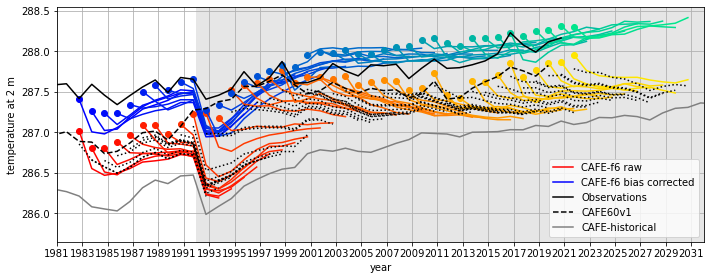

In [35]:
_ = plot_hindcasts(f6_hcst[[var]], f6_hcst_bc[[var]])

for i in f6_hcst_fit.init:
    plot_fit = f6_hcst_fit[var].sel(init=i).swap_dims({"lead": "time"})
    plt.plot(plot_fit.time, plot_fit, color="k", linestyle=":")

### Perhaps there is a clever way to utilize the historical run in the bias correction, but this is not it... 

### What about splitting about 1992 and using the Kharin approach?
Perhaps this will make the transition a little smoother, though fitting a trend over 20 years is questionable...

In [36]:
def bias_Kharin(hcst, obs):
    def _linear_fit_in_time(da):
        p = []
        for l in da.lead:
            ts = da.sel(lead=l).swap_dims({"init": "time"})
            p.append(ts.polyfit(dim="time", deg=1).expand_dims(lead=[l]))
        return xr.concat(p, dim="lead")

    hcst_coeffs = _linear_fit_in_time(hcst)
    hcst_coeffs = hcst_coeffs.rename(
        {n: n.removesuffix("_polyfit_coefficients") for n in hcst_coeffs.data_vars}
    )
    obs_coeffs = obs.polyfit("time", deg=1)
    obs_coeffs = obs_coeffs.rename(
        {n: n.removesuffix("_polyfit_coefficients") for n in obs_coeffs.data_vars}
    )

    slope_bias_coeffs = hcst_coeffs - obs_coeffs
    slope_bias = xr.polyval(hcst["init"], slope_bias_coeffs)
    hcst_slope_corrected = hcst - slope_bias

    bias = bias_mean(hcst_slope_corrected, obs)

    return slope_bias + bias

In [37]:
transition_year = 1992

period_1 = [
    cftime.DatetimeJulian(1973, 10, 1),
    cftime.DatetimeJulian(1992, 10, 1),
]  # 20 years, using initial dates < 1992
period_2 = [
    cftime.DatetimeJulian(2002, 10, 1),
    cftime.DatetimeJulian(2021, 10, 1),
]  # 20 years, using initial dates >= 1992

bias_1 = bias_Kharin(
    f5_hcst.where((f5_hcst.time >= period_1[0]) & (f5_hcst.time <= period_1[1])),
    obs.where((obs.time >= period_1[0]) & (obs.time <= period_1[1])),
)

bias_2 = bias_Kharin(
    f5_hcst.where((f5_hcst.time >= period_2[0]) & (f5_hcst.time <= period_2[1])),
    obs.where((obs.time >= period_2[0]) & (obs.time <= period_2[1])),
)

f6_hcst_bc1 = f6_hcst.sel(init=slice(None, str(transition_year - 1))) - bias_1
f6_hcst_bc2 = f6_hcst.sel(init=slice(str(transition_year), None)) - bias_2
f6_hcst_bc = xr.concat((f6_hcst_bc1, f6_hcst_bc2), dim="init")

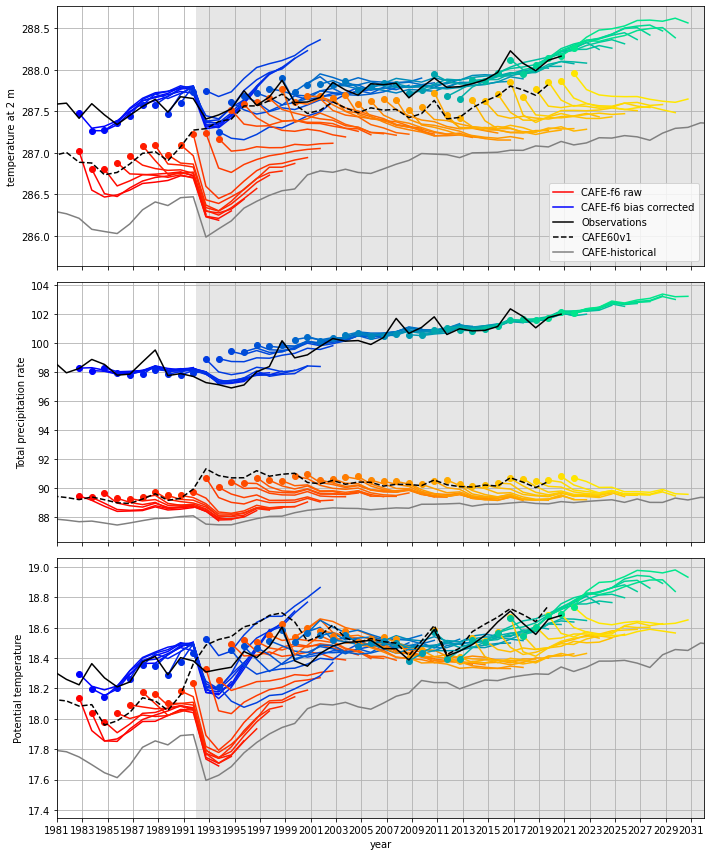

In [38]:
_ = plot_hindcasts(f6_hcst, f6_hcst_bc)

### This introduces a discontinuity. What about first removing the mean bias either side of 1992 first, then adjusting the slope?

In [39]:
transition_year = 1992

period_1 = [
    cftime.DatetimeJulian(1973, 10, 1),
    cftime.DatetimeJulian(1992, 10, 1),
]  # 20 years, using initial dates < 1992
period_2 = [
    cftime.DatetimeJulian(2002, 10, 1),
    cftime.DatetimeJulian(2021, 10, 1),
]  # 20 years, using initial dates >= 1992

bias_1 = bias_mean(
    f5_hcst.where((f5_hcst.time >= period_1[0]) & (f5_hcst.time <= period_1[1])),
    obs.where((obs.time >= period_1[0]) & (obs.time <= period_1[1])),
)

bias_2 = bias_mean(
    f5_hcst.where((f5_hcst.time >= period_2[0]) & (f5_hcst.time <= period_2[1])),
    obs.where((obs.time >= period_2[0]) & (obs.time <= period_2[1])),
)

f6_hcst_bc1 = f6_hcst.sel(init=slice(None, str(transition_year - 1))) - bias_1
f6_hcst_bc2 = f6_hcst.sel(init=slice(str(transition_year), None)) - bias_2
f6_hcst_bc = xr.concat((f6_hcst_bc1, f6_hcst_bc2), dim="init")


# Adjust the slope
period = [cftime.DatetimeJulian(1991, 10, 1), cftime.DatetimeJulian(2020, 10, 1)]

bias = bias_Kharin(
    f6_hcst_bc.where((f6_hcst.time >= period[0]) & (f6_hcst.time <= period[1])),
    obs.where((obs.time >= period[0]) & (obs.time <= period[1])),
)

f6_hcst_bc = f6_hcst_bc - bias

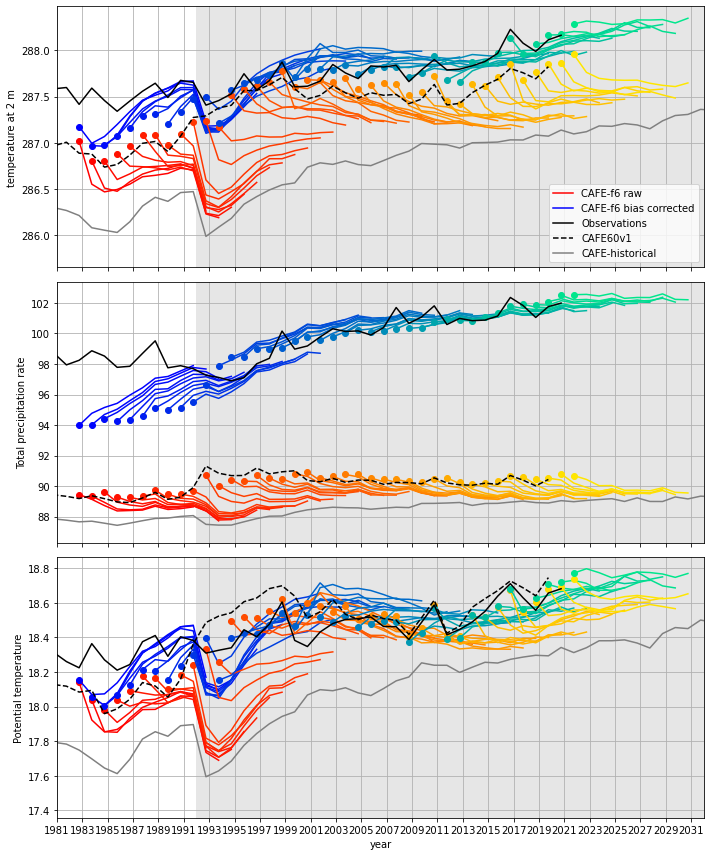

In [40]:
_ = plot_hindcasts(f6_hcst, f6_hcst_bc)

### The inclusion of the slope adjustment does not obviously improve things. What about just using the Kharin approach outright. This feels a little "off" because it's using a feature of the approach for the wrong reason...

In [41]:
period = [
    cftime.DatetimeJulian(1971, 10, 1),
    cftime.DatetimeJulian(2020, 10, 1),
]

bias = bias_Kharin(
    f5_hcst.where((f5_hcst.time >= period[0]) & (f5_hcst.time <= period[1])),
    obs.where((obs.time >= period[0]) & (obs.time <= period[1])),
)

f6_hcst_bc = f6_hcst - bias

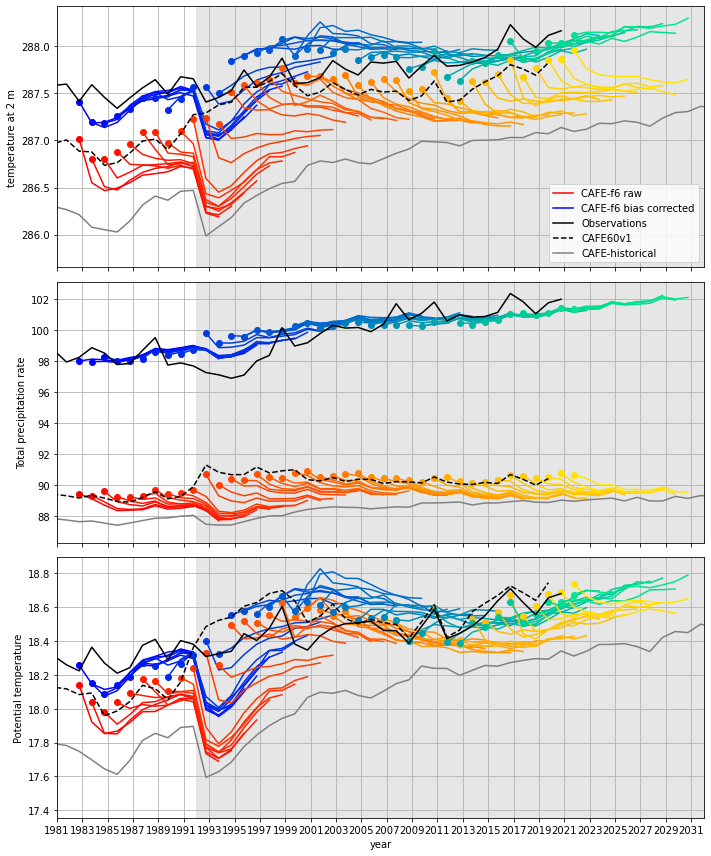

In [42]:
_ = plot_hindcasts(f6_hcst, f6_hcst_bc)

### Last thing to try: remove an offset calculated from CAFE-60, prior to performing the bias correction

In [43]:
# Subtract the offset
transition_year = 1992
period_1 = slice("1964", str(transition_year - 1))  # 28 years
period_2 = slice(str(transition_year), "2019")  # 28 years

bias_1 = cafe_60.sel(time=period_1).mean("time") - obs.sel(time=period_1).mean("time")
bias_2 = cafe_60.sel(time=period_2).mean("time") - obs.sel(time=period_2).mean("time")

f6_hcst_bc1 = f6_hcst.sel(init=slice(None, str(transition_year - 1))) - bias_1
f6_hcst_bc2 = f6_hcst.sel(init=slice(str(transition_year), None)) - bias_2
f6_hcst_bc = xr.concat((f6_hcst_bc1, f6_hcst_bc2), dim="init")

# Lead dependent bias correction
period = [cftime.DatetimeJulian(1991, 10, 1), cftime.DatetimeJulian(2020, 10, 1)]

bias = bias_mean(
    f6_hcst_bc.where((f6_hcst_bc.time >= period[0]) & (f6_hcst_bc.time <= period[1])),
    obs.where((obs.time >= period[0]) & (obs.time <= period[1])),
)

f6_hcst_bc = f6_hcst_bc - bias

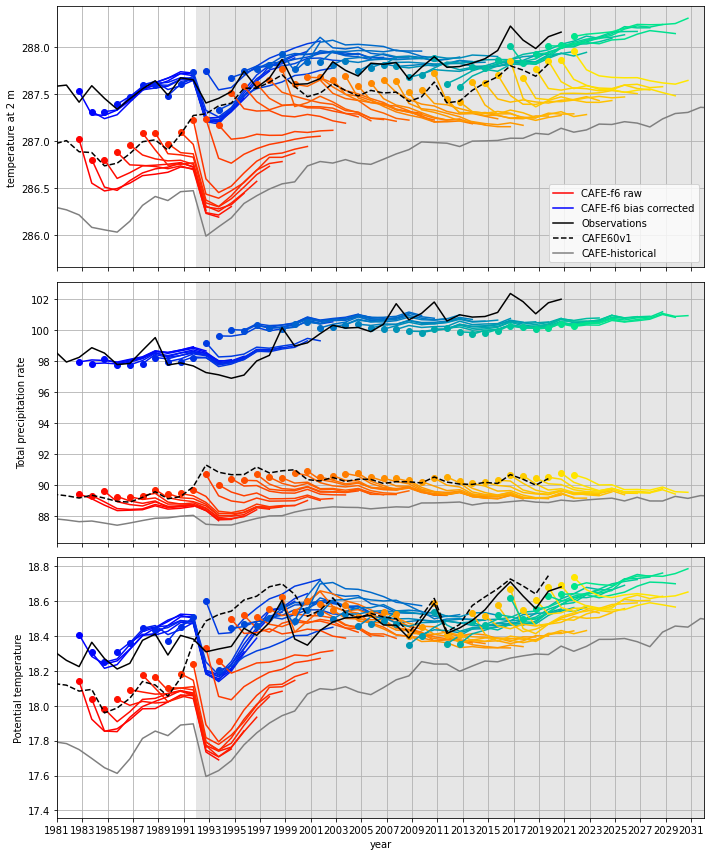

In [44]:
_ = plot_hindcasts(f6_hcst, f6_hcst_bc)

### Could we just do all verification relative to CAFE60v1? How would we interpret this? Can we justify that this is a sensible thing to do?

In [45]:
cluster.close()
client.close()